In [18]:
import requests
import io
import chardet
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [6]:
# get database
url = 'raw.githubusercontent.com'
username = 'brunoFNIR'
repository = 'Lung-Cancer-Prediction'
file_name = 'Lung-Cancer-Dataset.csv'
path = f'https://{url}/{username}/{repository}/main/{file_name}'

In [7]:
# download database
response = requests.get(path)
response.raise_for_status() #exception in case database couldnt be downloaded

with io.BytesIO(response.content) as byte_stream:
    result = chardet.detect(byte_stream.read())
    encoding = result['encoding']

df = pd.read_csv(path, encoding=encoding)

In [8]:
df.shape

(5000, 18)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AGE                     5000 non-null   int64  
 1   GENDER                  5000 non-null   int64  
 2   SMOKING                 5000 non-null   int64  
 3   FINGER_DISCOLORATION    5000 non-null   int64  
 4   MENTAL_STRESS           5000 non-null   int64  
 5   EXPOSURE_TO_POLLUTION   5000 non-null   int64  
 6   LONG_TERM_ILLNESS       5000 non-null   int64  
 7   ENERGY_LEVEL            5000 non-null   float64
 8   IMMUNE_WEAKNESS         5000 non-null   int64  
 9   BREATHING_ISSUE         5000 non-null   int64  
 10  ALCOHOL_CONSUMPTION     5000 non-null   int64  
 11  THROAT_DISCOMFORT       5000 non-null   int64  
 12  OXYGEN_SATURATION       5000 non-null   float64
 13  CHEST_TIGHTNESS         5000 non-null   int64  
 14  FAMILY_HISTORY          5000 non-null   

In [12]:
df.head()

,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES


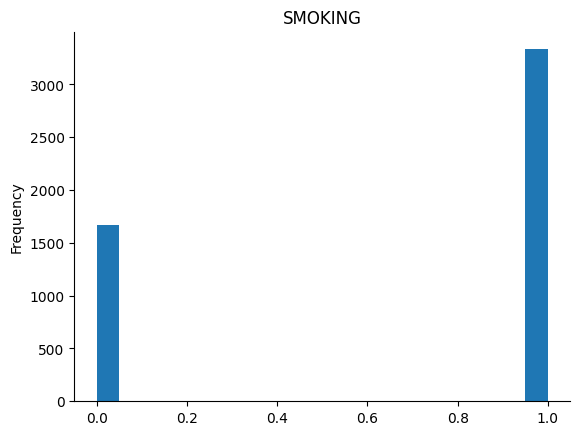

In [14]:
# @title SMOKING

from matplotlib import pyplot as plt
df['SMOKING'].plot(kind='hist', bins=20, title='SMOKING')
plt.gca().spines[['top', 'right',]].set_visible(False)

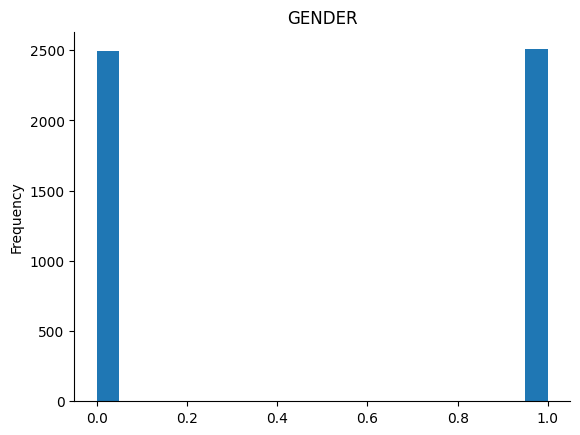

In [13]:
# @title GENDER

from matplotlib import pyplot as plt
df['GENDER'].plot(kind='hist', bins=20, title='GENDER')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
df.isnull().sum()

,0
AGE,0
GENDER,0
SMOKING,0
FINGER_DISCOLORATION,0
MENTAL_STRESS,0
EXPOSURE_TO_POLLUTION,0
LONG_TERM_ILLNESS,0
ENERGY_LEVEL,0
IMMUNE_WEAKNESS,0
BREATHING_ISSUE,0


In [19]:
# Model
X = df.drop('PULMONARY_DISEASE', axis=1)
y = df['PULMONARY_DISEASE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gnb = GaussianNB()

param_distributions = {
    'var_smoothing': uniform(1e-9, 1e-5)
}

model = RandomizedSearchCV(gnb,
                           param_distributions = param_distributions,
                           n_iter=100,
                           cv=5,
                           scoring = 'accuracy',
                           random_state=42)

model.fit(X_train, y_train)

best_params = model.best_params_
best_model = model.best_estimator_

In [20]:
print(best_params)

{'var_smoothing': np.float64(9.777211400638388e-07)}


In [22]:
y_pred = best_model.predict(X_test)



In [24]:
print ("Wrong classifications: {0} of {1}"
  .format((y_test != y_pred).sum(), df.shape[0]))

ac = best_model.score(X_test, y_test)
print('\nAccuracy: {0:.2f}%\n'.format(100*ac))

print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix, columns=['Predicted:No', 'Predicted:Yes'], index=['Actual:No', 'Actual:Yes'])
print(cnf_table)

Wrong classifications: 125 of 5000

Accuracy: 87.50%

              precision    recall  f1-score   support

          No       0.91      0.86      0.89       571
         Yes       0.83      0.89      0.86       429

    accuracy                           0.88      1000
   macro avg       0.87      0.88      0.87      1000
weighted avg       0.88      0.88      0.88      1000

            Predicted:No  Predicted:Yes
Actual:No            492             79
Actual:Yes            46            383
